In [2]:
import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from aggmap import AggMap, AggModel, loadmap

from aggmap import show

np.random.seed(666) #just for reaptable results


In [3]:
stages = ['MP', 'Stage_0', 'Stage_I_II', 'Stage_III_IV', ]
stage_names = ['MP', 'Stage 0', 'Stage I/II', 'Stage III/IV']

In [4]:
LASSO = [np.nan, 0.65, np.nan,0.71]
RF = [np.nan, 0.73, np.nan,0.83]

In [5]:
res = []
for i in stages:
    df = pd.read_csv('./results/each_fold_performance_results_%s.csv' % i, index_col=0)
    m = df.groupby('fold')['ROC-AUC'].mean().mean()
    s = df.groupby('fold')['ROC-AUC'].mean().std()
    res.append([m,s])

In [6]:
df = pd.DataFrame(res,index = stages, columns = ['mean', 'std'])
df.index = stage_names

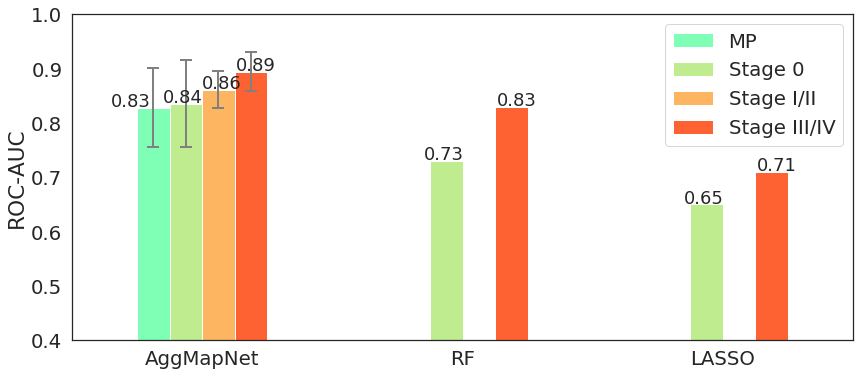

In [8]:
sns.set(style = 'white', font_scale=1.8)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6), sharex = True, sharey = True)

y1 = df['mean'].to_frame(name = 'AggMapNet')
y2 = pd.Series(RF, index =y1.index).to_frame(name = 'RF')
y3 = pd.Series(LASSO, index =y1.index).to_frame(name = 'LASSO')

y1_err = df['std'].to_frame(name = 'AggMapNet')
#y2_err = get_non_diag_mean(ourmodel_df)[1].to_frame(name = 'AggMapNet-STST')

y = y1 .join(y2).join(y3)
#y = y[['LASSO',  'RF', 'AggMapNet']]


y_err = y1_err.T #.join(y2_err)
y = y.T 

color = sns.color_palette("rainbow_r",15).as_hex() #PiYG
color = [color[7], color[5], color[3], color[1] ]

y.plot(kind = 'bar',ax = ax, color = color, yerr= y_err,ylim = (0.5, 0.96), error_kw=dict(ecolor='gray', lw=2, capsize=6, capthick=2))
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('')


for x_, y_ in enumerate(y['MP'].values):
    ax.annotate('%.2f' % y_, xy = (x_-0.35, y_+0.002), fontsize =18)

for  x_, y_ in enumerate(y['Stage 0'].values):
    ax.annotate('%.2f' % y_, xy = (x_-0.15, y_+0.002), fontsize =18)
    
for  x_, y_ in enumerate(y['Stage I/II'].values):
    ax.annotate('%.2f' % y_, xy = (x_, y_+0.002), fontsize =18)
        
for  x_, y_ in enumerate(y['Stage III/IV'].values):
    ax.annotate('%.2f' % y_, xy = (x_+0.13, y_+0.002), fontsize =18)
    
ax.set_xticklabels(labels = y.index,rotation=0)
ax.set_ylim(0.4,1.0)
    
fig.savefig('./results/CRCS_performance_comparasion_mean.png', bbox_inches='tight', dpi=400) 

In [7]:

data = pd.read_csv('./data/dfx.csv', index_col = 0)
label = pd.read_csv('./data/dfy.csv', index_col = 0)

mp = loadmap('./CRC_stage.mp')

In [8]:
dfx = np.log(data + 1e-8)


In [9]:
X = mp.batch_transform(dfx.values,  scale_method = 'standard') # NaN values should be the lowest value

100%|##########| 317/317 [00:30<00:00, 10.24it/s]


In [10]:
idx = label.reset_index().groupby('Group').apply(lambda x:x.index.tolist())
idx = idx.loc[['Healthy', 'MP', 'Stage_0', 'Stage_I_II', 'Stage_III_IV']]
idx

Group
Healthy         [1, 2, 5, 7, 8, 9, 12, 16, 17, 18, 19, 25, 26,...
MP              [0, 6, 11, 22, 23, 24, 41, 47, 78, 79, 84, 85,...
Stage_0         [45, 48, 52, 59, 62, 67, 105, 115, 150, 168, 1...
Stage_I_II      [3, 4, 13, 15, 20, 29, 31, 32, 38, 39, 42, 44,...
Stage_III_IV    [10, 14, 21, 27, 30, 37, 43, 66, 71, 76, 81, 8...
dtype: object

In [11]:
row_names = ['Healthy', 'MP', 'Stage 0', 'Stage I/II', 'Stage III/IV']

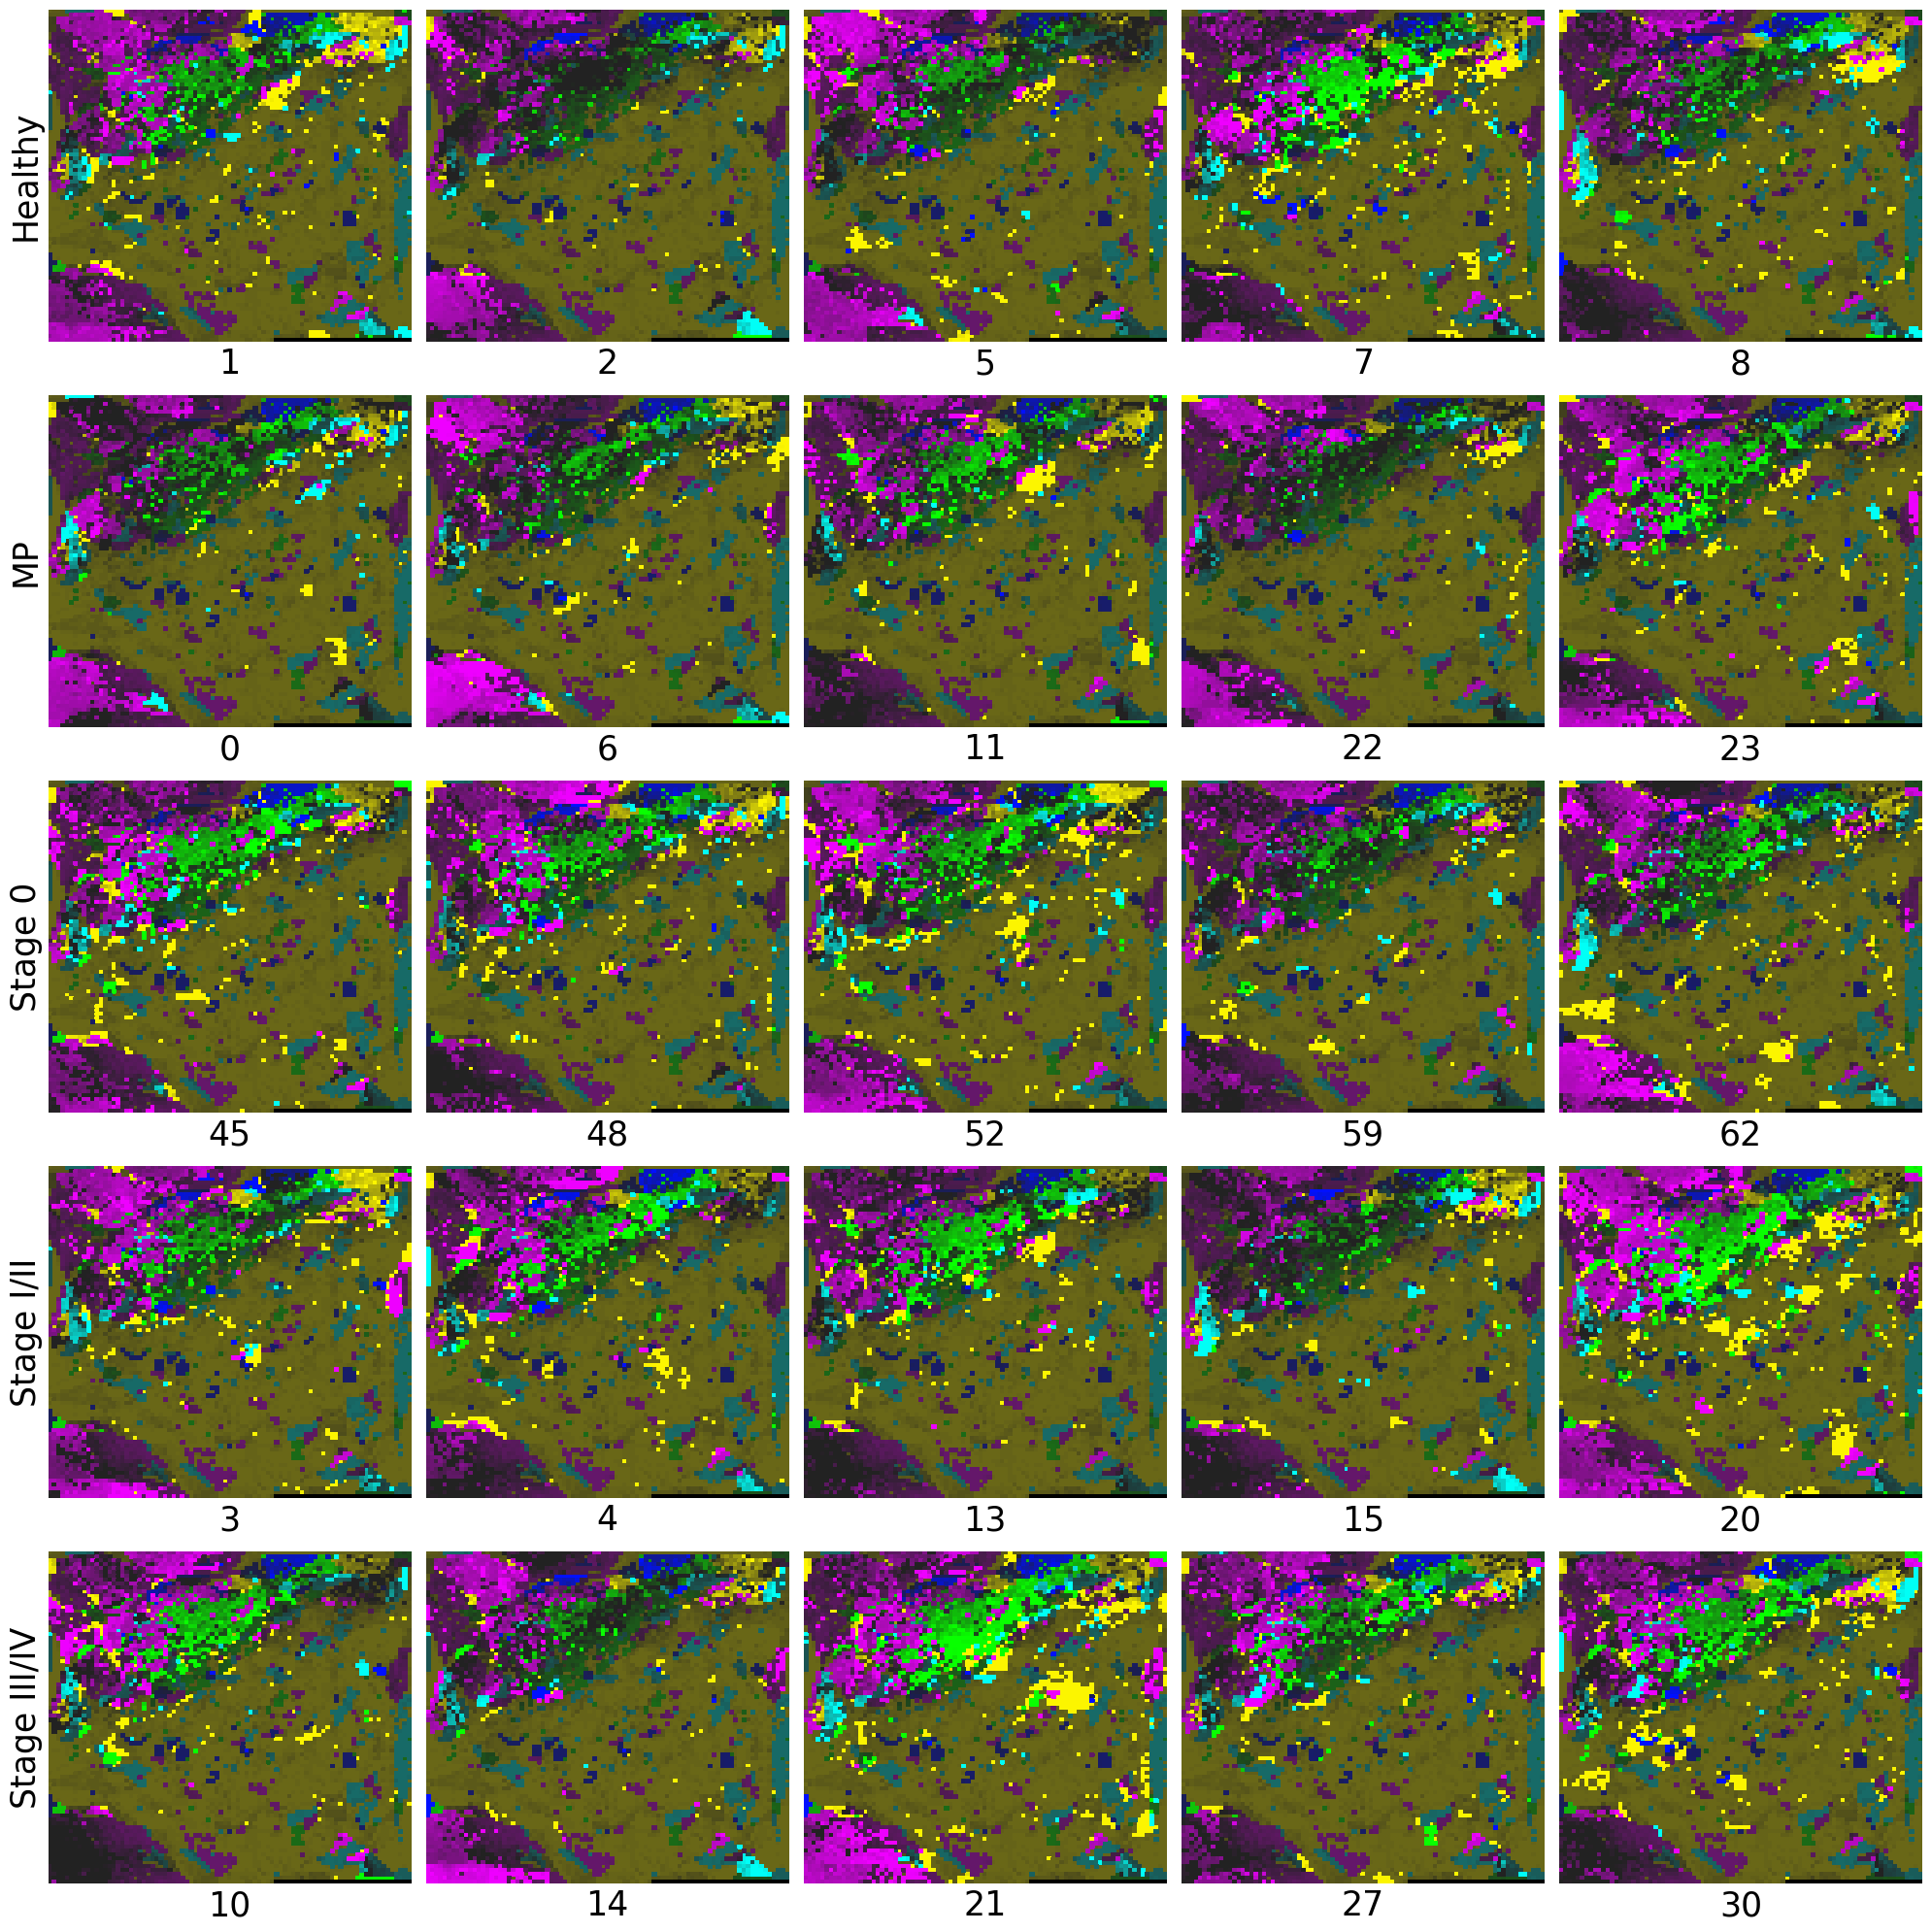

In [82]:
sns.reset_orig()
fontsize = 25
ncols = 5
fig, axes = plt.subplots(nrows=5, ncols=ncols, figsize=(20,20), sharex = True, sharey = True)

rows = idx.index

for row, row_ax in zip(rows, axes):
    pidx = idx.loc[row][:ncols]        
    for pid, ax in zip(pidx, row_ax):
        pid_name = str(pid)
        x = X[pid]
        #x = ((x - x.min()) * (1/(x.max() - x.min()) * 255))
        #ax.imshow(x.sum(axis=-1))
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=2, vmin=-0.5, vmax=0.9)
        #mx = pd.Series(x.sum(axis=-1).reshape(-1,)).describe()['75%']
        #show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=mx, vmin = -1, vmax = 1)
        ax.set_xlabel(pid_name, fontsize = fontsize) 
        
        
for ax, row in zip(axes[:,0], row_names):
    ax.set_ylabel(row, fontsize = fontsize)  

fig.tight_layout()
#fig.savefig('./results/fmaps.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./results/fmaps.png', bbox_inches='tight', dpi=400) 

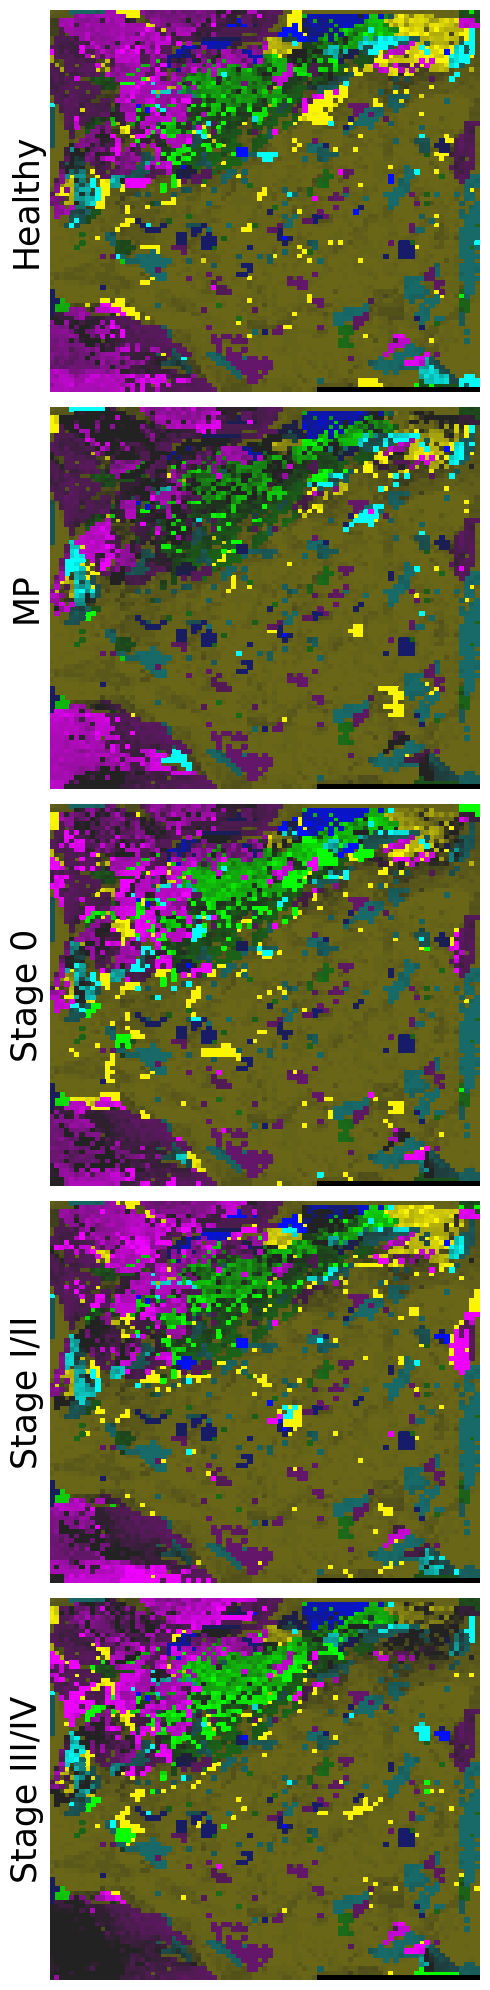

In [81]:
sns.reset_orig()
fontsize = 25
ncols = 1
fig, axes = plt.subplots(nrows=5, ncols=ncols, figsize=(5,20), sharex = True, sharey = True)

sidx = idx.apply(lambda x:x[0]).tolist()

for pid, ax, row in zip(sidx, axes.ravel(), row_names):
    x = X[pid]
    #ax.imshow(x.sum(axis=-1))
    mx = pd.Series(x.sum(axis=-1).reshape(-1,)).describe()['75%']

    show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=2, vmin=-0.5, vmax=0.9)
    #ax.set_xlabel(pid_name, fontsize = fontsize) 
    ax.set_ylabel(row, fontsize = fontsize)  

fig.tight_layout()

#fig.savefig('./results/fmaps.png', bbox_inches='tight', dpi=400) 

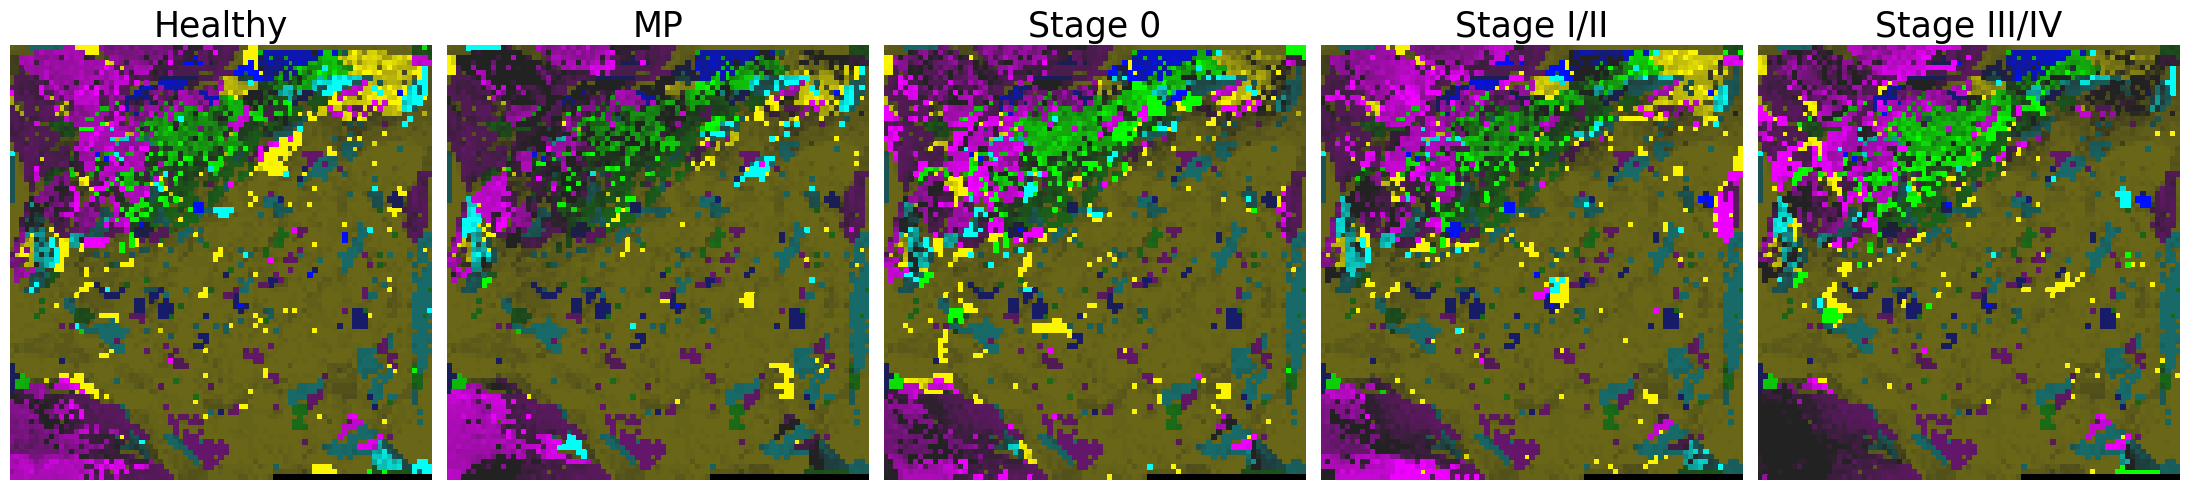

In [114]:
sns.reset_orig()
fontsize = 25

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(22, 5), sharex = True, sharey = True)

sidx = idx.apply(lambda x:x[0]).tolist()

for pid, ax, row in zip(sidx, axes.ravel(), row_names):
    x = X[pid]
    #ax.imshow(x.sum(axis=-1))
    mx = pd.Series(x.sum(axis=-1).reshape(-1,)).describe()['75%']

    show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=2, vmin=-0.5, vmax=0.9)
    #ax.set_xlabel(pid_name, fontsize = fontsize) 
    ax.set_title(row, fontdict = {'fontsize':fontsize}, loc='center')  

fig.tight_layout()

fig.savefig('./results/fmaps-1rows.png', bbox_inches='tight', dpi=400) 